# this notebook is only for SNN implementation

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('resampled_plga_data.csv')


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import torch
from torch.utils.data import Dataset, DataLoader
import joblib

# 1. Load the resampled dataset
df = pd.read_csv('resampled_plga_data.csv')

# 2. Extract features and target
X = df.iloc[:, :-1].values  # All columns except the last one
y = df['Release_Classification'].values

# 3. Normalize features (important for distance-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Create a dictionary mapping class labels to indices
unique_classes = np.unique(y)
class_indices = {cls: np.where(y == cls)[0] for cls in unique_classes}

# 5. Create positive and negative pairs
positive_pairs = []  # Pairs from same class (label=1)
negative_pairs = []  # Pairs from different classes (label=0)

# Generate positive pairs (same class)
for cls, indices in class_indices.items():
    # Get all possible pairs within this class
    for i, j in combinations(indices, 2):
        positive_pairs.append((X_scaled[i], X_scaled[j], 1))
        
    # Limit the number of pairs per class if needed
    # if len(positive_pairs) > MAX_PAIRS:
    #     break

# Generate negative pairs (different classes)
# For balance, generate roughly the same number of negative pairs as positive pairs
num_negative_pairs = len(positive_pairs)
negative_pair_count = 0

# Get all classes
classes = list(class_indices.keys())

while negative_pair_count < num_negative_pairs:
    # Randomly select two different classes
    cls1, cls2 = np.random.choice(classes, 2, replace=False)
    
    # Randomly select one sample from each class
    i = np.random.choice(class_indices[cls1])
    j = np.random.choice(class_indices[cls2])
    
    negative_pairs.append((X_scaled[i], X_scaled[j], 0))
    negative_pair_count += 1

# 6. Combine and shuffle pairs
all_pairs = positive_pairs + negative_pairs
np.random.shuffle(all_pairs)

# 7. Split data into anchors, positives/negatives, and labels
anchors = np.array([p[0] for p in all_pairs])
others = np.array([p[1] for p in all_pairs])
labels = np.array([p[2] for p in all_pairs])

# 8. Create PyTorch Dataset
class SiameseDataset(Dataset):
    def __init__(self, anchors, others, labels):
        self.anchors = anchors
        self.others = others
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (torch.tensor(self.anchors[idx], dtype=torch.float32),
                torch.tensor(self.others[idx], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32))

# 9. Create train/validation split
train_size = int(0.8 * len(labels))
indices = np.random.permutation(len(labels))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = SiameseDataset(anchors[train_indices], others[train_indices], labels[train_indices])
val_dataset = SiameseDataset(anchors[val_indices], others[val_indices], labels[val_indices])

# 10. Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Print some statistics
print(f"Total pairs: {len(all_pairs)}")
print(f"Positive pairs: {len(positive_pairs)}")
print(f"Negative pairs: {len(negative_pairs)}")
print(f"Training pairs: {len(train_indices)}")
print(f"Validation pairs: {len(val_indices)}")

# Example of accessing a batch
for anchor_batch, other_batch, label_batch in train_loader:
    print(f"Anchor batch shape: {anchor_batch.shape}")
    print(f"Other batch shape: {other_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break
    # Save the prepared data

np.savez('siamese_pairs.npz', 
             anchors=anchors,
             others=others,
             labels=labels,
             train_indices=train_indices,
             val_indices=val_indices)

    # Also save scaler for future preprocessing
joblib.dump(scaler, 'feature_scaler.joblib')

Total pairs: 1393326
Positive pairs: 696663
Negative pairs: 696663
Training pairs: 1114660
Validation pairs: 278666
Anchor batch shape: torch.Size([32, 16])
Other batch shape: torch.Size([32, 16])
Label batch shape: torch.Size([32])


['feature_scaler.joblib']

Using device: cpu
Epoch 1/5:
  Train Loss: 0.1616
  Val Loss: 0.0210, Val Accuracy: 0.9918, Val AUC: 1.0000
  Saved new best model!
Epoch 2/5:
  Train Loss: 0.1121
  Val Loss: 0.0510, Val Accuracy: 0.9758, Val AUC: 0.9999
Epoch 3/5:
  Train Loss: 0.1082
  Val Loss: 0.0250, Val Accuracy: 0.9915, Val AUC: 0.9999
Epoch 4/5:
  Train Loss: 0.1049
  Val Loss: 0.0235, Val Accuracy: 0.9844, Val AUC: 1.0000
Epoch 5/5:
  Train Loss: 0.1072
  Val Loss: 0.0729, Val Accuracy: 0.9913, Val AUC: 0.9998


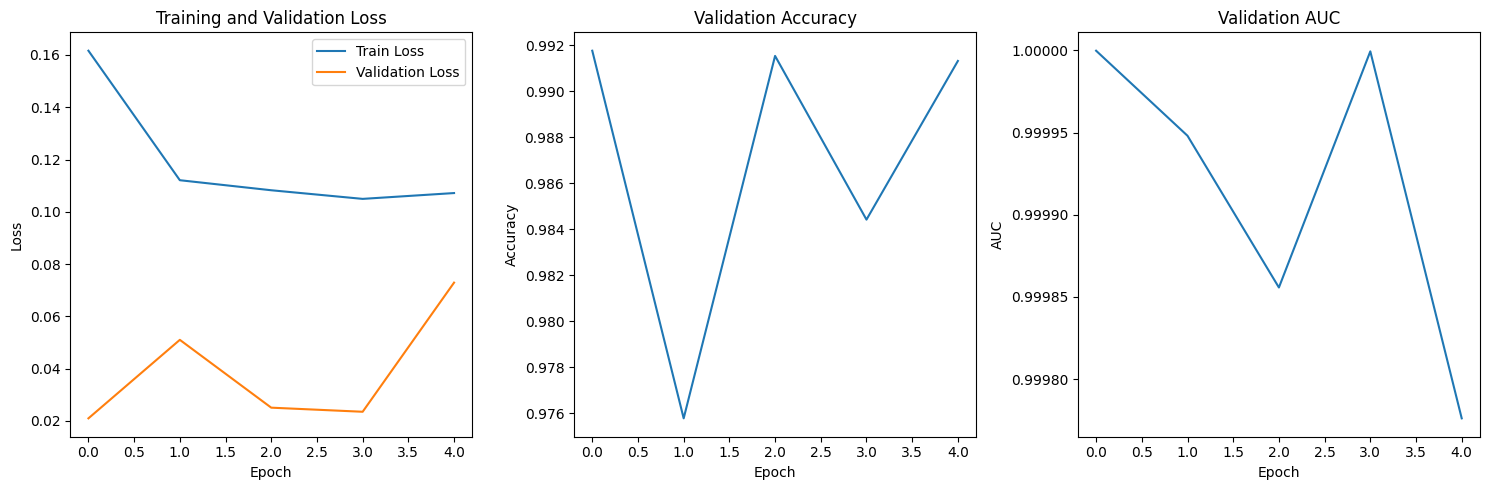

F1 Score: 0.9913


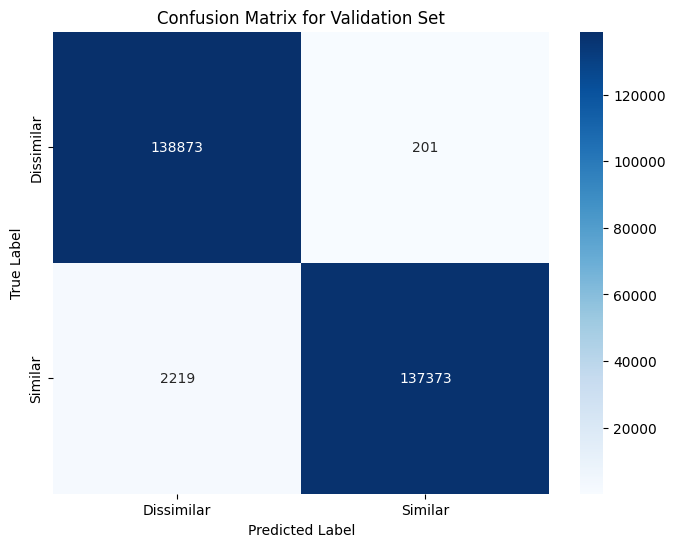


--- Example: Predicting similarity between two samples ---
Sample 1 (idx 784) original class: Slow
Sample 2 (idx 819) original class: Slow
Predicted Distance: 0.0534
Predicted Similarity Score: 0.9493
Predicted as Similar: True

--- Example: Predicting similarity for a known validation pair ---
True Label for pair: Dissimilar (Label: 0)
Predicted Distance: 1.6430
Predicted Similarity Score: 0.3784
Predicted as Similar: False


In [13]:
# Add a new cell for the Siamese model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Define the Siamese Neural Network
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim):
        super(SiameseNetwork, self).__init__()
        
        # Shared encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32)  # Final embedding dimension
        )
        
    def forward_one(self, x):
        return self.encoder(x)
    
    def forward(self, x1, x2):
        # Get embeddings for both inputs
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        return output1, output2

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        # Calculate euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        # Contrastive loss formula:
        # For similar pairs (label=1): distance^2
        # For dissimilar pairs (label=0): max(0, margin - distance)^2
        loss_similar = label * torch.pow(euclidean_distance, 2)
        loss_dissimilar = (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        
        return torch.mean(loss_similar + loss_dissimilar)

# Initialize model, loss and optimizer
input_dim = X_scaled.shape[1]  # Number of features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SiameseNetwork(input_dim).to(device)
criterion = ContrastiveLoss(margin=2.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    
    for anchor, other, label in train_loader:
        # Move data to device
        anchor, other, label = anchor.to(device), other.to(device), label.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output1, output2 = model(anchor, other)
        
        # Calculate loss
        loss = criterion(output1, output2, label)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

# Validation function
def validate(model, val_loader, criterion, device, threshold=0.5):
    model.eval()
    val_loss = 0.0
    all_distances = []
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for anchor, other, label in val_loader:
            # Move data to device
            anchor, other, label = anchor.to(device), other.to(device), label.to(device)
            
            # Forward pass
            output1, output2 = model(anchor, other)
            
            # Calculate loss
            loss = criterion(output1, output2, label)
            val_loss += loss.item()
            
            # Calculate distance
            distances = F.pairwise_distance(output1, output2).cpu().numpy()
            
            # Convert distances to predictions (low distance = similar = 1, high distance = dissimilar = 0)
            predictions = (distances < threshold).astype(int)
            
            all_distances.extend(distances)
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predictions)
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    
    # Calculate AUC (inverted distances because smaller distance = higher similarity)
    auc = roc_auc_score(all_labels, [-d for d in all_distances])
    
    return val_loss / len(val_loader), accuracy, auc

# Function to predict similarity between two feature vectors
def predict_similarity(model, features1, features2, device, threshold):
    model.eval()  # Set model to evaluation mode
    
    # Convert 1D numpy arrays to 2D tensors (batch_size=1) and move to device
    t1 = torch.tensor(features1, dtype=torch.float32).unsqueeze(0).to(device)
    t2 = torch.tensor(features2, dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad(): # No gradients needed for inference
        output1, output2 = model(t1, t2)
        
    # Calculate Euclidean distance
    distance = F.pairwise_distance(output1, output2).item() # .item() to get a Python number
    
    # Determine if similar based on the threshold
    is_similar = distance < threshold
    
    # Calculate a similarity score (e.g., 0 to 1)
    # Using the margin from the global 'criterion' object for normalization.
    # This score is 1 if distance is 0, 0 if distance >= criterion.margin, and linear in between.
    similarity_score = max(0.0, (criterion.margin - distance) / criterion.margin)

    return {
        'distance': distance,
        'similarity_score': similarity_score,
        'is_similar': is_similar
    }

# Training loop
num_epochs = 5
train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []
best_val_auc = 0.0

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss, val_accuracy, val_auc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_aucs.append(val_auc)
    
    # Print metrics
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_siamese_model.pt')
        print("  Saved new best model!")

# Plot training progress
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(val_aucs)
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation AUC')

plt.tight_layout()
plt.show()

# Get predictions and true labels from the validation set
model.eval()
all_labels_val = []
all_predictions_val = []
threshold = 0.5 # Using the same threshold as in validation

with torch.no_grad():
    for anchor, other, label in val_loader:
        anchor, other, label = anchor.to(device), other.to(device), label.to(device)
        output1, output2 = model(anchor, other)
        distances = F.pairwise_distance(output1, output2).cpu().numpy()
        predictions = (distances < threshold).astype(int)
        
        all_labels_val.extend(label.cpu().numpy().astype(int))
        all_predictions_val.extend(predictions)

# Calculate Confusion Matrix
cm = confusion_matrix(all_labels_val, all_predictions_val)
f1 = f1_score(all_labels_val, all_predictions_val)

print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dissimilar', 'Similar'], yticklabels=['Dissimilar', 'Similar'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Example of using the predict_similarity function
# Take two samples from the validation set (or any new data)
# Ensure they are scaled using the same scaler
if len(val_dataset) >= 2:
    sample_idx1, sample_idx2 = 0, 1 # Or any other indices

    # Get the original scaled features for these samples
    # We need to find them in the 'anchors' or 'others' arrays using val_indices
    # This is a bit convoluted because SiameseDataset stores pairs.
    # For a simpler example, let's just pick two random samples from X_scaled
    # and assume a true relationship (or lack thereof) for demonstration.

    # Let's pick two samples from X_scaled that were part of the validation set
    # This requires mapping val_indices back to the original X_scaled indices,
    # which is not directly stored.
    # Instead, let's just use two arbitrary samples from X_scaled for demonstration.
    
    # If you want to test with actual validation samples:
    # anchor_sample_val, other_sample_val, label_sample_val = val_dataset[0]
    # sample1_features = anchor_sample_val.cpu().numpy()
    # sample2_features = other_sample_val.cpu().numpy()
    # true_label_example = int(label_sample_val.item())

    # For a generic example with two random scaled samples:
    idx1, idx2 = np.random.choice(len(X_scaled), 2, replace=False)
    sample1_features = X_scaled[idx1]
    sample2_features = X_scaled[idx2]
    # We don't know the "true" pair label for these random samples without looking up 'y'
    # This is just to show the function usage.

    print(f"\n--- Example: Predicting similarity between two samples ---")
    print(f"Sample 1 (idx {idx1}) original class: {y[idx1]}")
    print(f"Sample 2 (idx {idx2}) original class: {y[idx2]}")
    
    # Predict similarity
    prediction_result = predict_similarity(model, sample1_features, sample2_features, device, threshold=threshold)
    
    print(f"Predicted Distance: {prediction_result['distance']:.4f}")
    print(f"Predicted Similarity Score: {prediction_result['similarity_score']:.4f}")
    print(f"Predicted as Similar: {prediction_result['is_similar']}")
    
    # For a known pair from the validation set
    if len(val_dataset) > 0:
        anchor_ex, other_ex, label_ex = val_dataset[0] # Get first pair from validation
        label_ex_np = int(label_ex.item())

        print(f"\n--- Example: Predicting similarity for a known validation pair ---")
        print(f"True Label for pair: {'Similar' if label_ex_np == 1 else 'Dissimilar'} (Label: {label_ex_np})")
        
        prediction_result_known = predict_similarity(model, anchor_ex.cpu().numpy(), other_ex.cpu().numpy(), device, threshold=threshold)
        
        print(f"Predicted Distance: {prediction_result_known['distance']:.4f}")
        print(f"Predicted Similarity Score: {prediction_result_known['similarity_score']:.4f}")
        print(f"Predicted as Similar: {prediction_result_known['is_similar']}")

else:
    print("Validation dataset is empty, skipping similarity prediction example.")


In [11]:

# Example: Compare two random samples
idx1, idx2 = np.random.choice(len(X_scaled), 2, replace=False)
sample1 = X_scaled[idx1]
sample2 = X_scaled[idx2]
true_label = 1 if y[idx1] == y[idx2] else 0

result = predict_similarity(model, sample1, sample2, device)
print(f"Sample 1 class: {y[idx1]}")
print(f"Sample 2 class: {y[idx2]}")
print(f"True similarity: {'Similar' if true_label == 1 else 'Dissimilar'}")
print(f"Predicted distance: {result['distance']:.4f}")
print(f"Similarity score: {result['similarity_score']:.4f}")
# Function to get confidence values from Conf_classified.csv
def get_confidence_for_predictions(model, sample1, sample2, device, threshold=0.5, confidence_csv_path=r'D:\Bunker\OneDrive - Amrita vishwa vidyapeetham\BaseCamp\ML\PLAI\IMI_EndSem_Project\Gagabool\Conf_classified_separate.csv'):
    # Load the confidence data
    confidence_df = pd.read_csv(confidence_csv_path)
    
    # Get similarity prediction from the model
    result = predict_similarity(model, sample1, sample2, device, threshold)
    
    # Get the class of sample2 (reference formulation)
    sample2_idx = np.where((X_scaled == sample2).all(axis=1))[0]
    if len(sample2_idx) > 0:
        sample2_class = y[sample2_idx[0]]
        
        # Find confidence for this class in the CSV
        if sample2_class in confidence_df['Confidence_Level'].values:
            class_confidence = confidence_df.loc[confidence_df['Confidence_Level'] == sample2_class, 'Confidence_Level'].values[0]
            confidence_level = "High" if class_confidence =="High"  else "Medium" if class_confidence == "M" else "Low"
            
            # Return enhanced result with confidence information
            return {
                **result,
                'reference_class': sample2_class,
                'reference_confidence': class_confidence,
                'confidence_level': confidence_level,
                'weighted_score': result['similarity_score'] * class_confidence
            }
    
    # If we couldn't find confidence info, return the original result
    return result

# Example: Compare with confidence information
idx1, idx2 = np.random.choice(len(X_scaled), 2, replace=False)
sample1 = X_scaled[idx1]
sample2 = X_scaled[idx2]
true_label = 1 if y[idx1] == y[idx2] else 0

# Get prediction with confidence
try:
    result_with_confidence = get_confidence_for_predictions(model, sample1, sample2, device)
    print(f"Sample 1 class: {y[idx1]}")
    print(f"Sample 2 class (reference): {y[idx2]}")
    print(f"True similarity: {'Similar' if true_label == 1 else 'Dissimilar'}")
    print(f"Predicted distance: {result_with_confidence['distance']:.4f}")
    print(f"Similarity score: {result_with_confidence['similarity_score']:.4f}")
    print(f"Predicted as: {'Similar' if result_with_confidence['is_similar'] else 'Dissimilar'}")
    
    if 'reference_confidence' in result_with_confidence:
        print(f"Reference class: {result_with_confidence['reference_class']}")
        print(f"Reference confidence: {result_with_confidence['reference_confidence']:.4f} ({result_with_confidence['confidence_level']})")
        print(f"Weighted similarity: {result_with_confidence['weighted_score']:.4f}")
except Exception as e:
    print(f"Error accessing confidence data: {e}")
    print("Falling back to standard prediction...")
    result = predict_similarity(model, sample1, sample2, device)
    print(f"Similarity score: {result['similarity_score']:.4f}")


Sample 1 class: Moderate
Sample 2 class: Moderate
True similarity: Similar
Predicted distance: 0.0458
Similarity score: 0.9562
Sample 1 class: Moderate
Sample 2 class (reference): Slow
True similarity: Dissimilar
Predicted distance: 1.4220
Similarity score: 0.4129
Predicted as: Dissimilar


In [5]:
import joblib
import os

# Create a directory for saved files if it doesn't exist
save_dir = 'saved_model'
os.makedirs(save_dir, exist_ok=True)

# Save the model, scaler, and other important variables
joblib.dump(scaler, os.path.join(save_dir, 'feature_scaler.joblib'))
joblib.dump(unique_classes, os.path.join(save_dir, 'unique_classes.joblib'))

# Save training history
history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_aucs': val_aucs
}
joblib.dump(history, os.path.join(save_dir, 'training_history.joblib'))

# Save model state dict
torch.save(model.state_dict(), os.path.join(save_dir, 'siamese_model.pt'))

print(f"All files saved in '{save_dir}' directory")

All files saved in 'saved_model' directory


In [6]:
# --- Test with predefined Formulations A & B ---
# Feature order:
# ['LA/GA','Polymer_MW','CL Ratio','Drug_Tm','Drug_Pka',
#  'Initial D/M ratio','DLC','SA-V','SE','Drug_Mw',
#  'Drug_TPSA','Drug_NHA','Drug_LogP','T=0.25','T=0.5','T=1.0']

# 1. define Formulations
formA = [1.0, 25000, 0.5, 150.0, 7.0,    0.1, 0.08, 1.0, 0.5, 300.0,   90.0, 5.0, 3.0, 0.1,  0.2,  0.3]
formB = [1.5, 30000, 0.6, 160.0, 7.5,    0.15,0.12, 1.2, 0.6, 320.0,   95.0, 6.0, 3.2, 0.12, 0.22, 0.32]

# 2. scale
A_scaled = scaler.transform(np.array(formA).reshape(1, -1))[0]
B_scaled = scaler.transform(np.array(formB).reshape(1, -1))[0]

# 3. predict via Siamese model
model.load_state_dict(torch.load('best_siamese_model.pt'))
model.eval()
res = predict_similarity(model, A_scaled, B_scaled, device)

# 4. find nearest neighbor in raw feature space to get 'true' class
idxA = np.linalg.norm(X_scaled - A_scaled, axis=1).argmin()
idxB = np.linalg.norm(X_scaled - B_scaled, axis=1).argmin()
classA = y[idxA]
classB = y[idxB]
true_sim = 'YES' if classA == classB else 'NO'

# 5. print results
print(f"Formulation A nearest class : {classA}")
print(f"Formulation B nearest class : {classB}")
print(f"True similarity           : {true_sim}")
print(f"Predicted distance        : {res['distance']:.4f}")
print(f"Similarity score          : {res['similarity_score']:.4f}")
print(f"Predicted similar?        : {'YES' if res['is_similar'] else 'NO'}")

Formulation A nearest class : Slow
Formulation B nearest class : Slow
True similarity           : YES
Predicted distance        : 3248.7017
Similarity score          : 0.0003
Predicted similar?        : NO


In [12]:
# --- Test with predefined Formulation A & B ---
# Feature order: 
# ['LA/GA','Polymer_MW','CL Ratio','Drug_Tm','Drug_Pka',
#  'Initial D/M ratio','DLC','SA-V','SE','Drug_Mw',
#  'Drug_TPSA','Drug_NHA','Drug_LogP','T=0.25','T=0.5','T=1.0']

formA = [1.0, 25000, 0.5, 150.0, 7.0,    0.1, 0.08, 1.0, 0.5, 300.0,   90.0, 5.0, 3.0, 0.1,  0.2,  0.3]
formB = [1.2, 39000, 0.6, 169.0, 7.7,    0.156,0.12, 1.4, 0.9, 321.0,   95.0, 8.0, 4.2, 0.12, 0.22, 0.32]

# scale
A_scaled = scaler.transform(np.array(formA).reshape(1,-1))[0]
B_scaled = scaler.transform(np.array(formB).reshape(1,-1))[0]

# predict
res = predict_similarity(model, A_scaled, B_scaled, device)

# find nearest neighbor in dataset to estimate true classes
idxA = np.linalg.norm(X_scaled - A_scaled, axis=1).argmin()
idxB = np.linalg.norm(X_scaled - B_scaled, axis=1).argmin()
classA = y[idxA]
classB = y[idxB]
true_sim = 'YES' if classA == classB else 'NO'

# print results
print(f"Formulation A nearest class: {classA}")
print(f"Formulation B nearest class: {classB}")
print(f"True similarity: {true_sim}")
print(f"Predicted distance : {res['distance']:.4f}")
print(f"Similarity score   : {res['similarity_score']:.4f}")
print(f"Predicted similar? : {'YES' if res['is_similar'] else 'NO'}")

Formulation A nearest class: Slow
Formulation B nearest class: Slow
True similarity: YES
Predicted distance : 3408.1633
Similarity score   : 0.0003
Predicted similar? : NO
